In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_auc_score

# Full case analysis

- For the moddeling appraoch I have decided to build RF model to find important features that can be later used in logistic regression for interparetability. At the same time we can compare the effectivness of linear vs complex algorithm on this problem. 
- for model evaluation train/test data split with stratification to account for the data inbalance.

In [2]:
def split_data(df):
    X, default = df[x_labels], df['default']
    X_train, X_test, y_train, y_test = train_test_split(X, default, stratify=default,test_size=0.33, random_state=42)
    return X, default,  X_train, X_test, y_train, y_test

df = pd.read_csv('data/full_case.csv', index_col=0)
# columns of variable names
x_labels = [i for i in df.columns if i not in ['ID', 'obs_date','default']]
X, default, X_train, X_test, y_train, y_test = split_data(df)

## Random forest

Generaly speaking leaving it up to default options of random forest usually works, I just want to get a base line for further tuning and test the imputed set. 


Things i tested were: 
- different number of trees, 
- add some pruning 
- adding more weight on default observations to prioritize this predictions. 

Im not sure if there is a real problem with false classifying a default, im thinking of it in like a sick patient scenario where it results in additional tests to find if the diagnose is real. But its definetly important to catch as many defaults as possible while not having to verify all of the false classified companies later on.

              precision    recall  f1-score   support

  No default       0.98      0.88      0.93     33790
     Default       0.28      0.76      0.41      2084

    accuracy                           0.87     35874
   macro avg       0.63      0.82      0.67     35874
weighted avg       0.94      0.87      0.90     35874



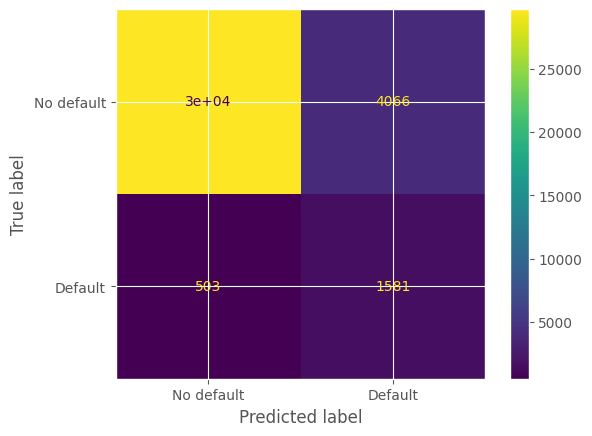

In [3]:
def train_rf(X_train, y_train, y_test):
    clf = RandomForestClassifier(
        n_estimators = 1000,
        class_weight={0: 1, 1: 10},
        ccp_alpha = 0.001, 
        random_state=0, n_jobs=4)
    clf.fit(X_train, y_train)

    y_p = clf.predict(X_test)
    print(classification_report(y_test, y_p, target_names=['No default', 'Default']))

    cm = confusion_matrix(y_test, y_p, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No default', 'Default'])
    disp.plot()
    plt.show()
    return clf

clf_rf = train_rf(X_train, y_train, y_test)

So generaly we catch around 75% observations out of all defaults. The prediction is not so pure only 1600 out of 5600 observations were true defaults is a conesquence of prioritizing defaults.

### RF feature importance

We use feature importance as a feature selection algorithm for logistics regression. There is a lot of unexplained uncertainty when we looking at the standard devaitions but by taking top 10 of performing variables is a good starting point.

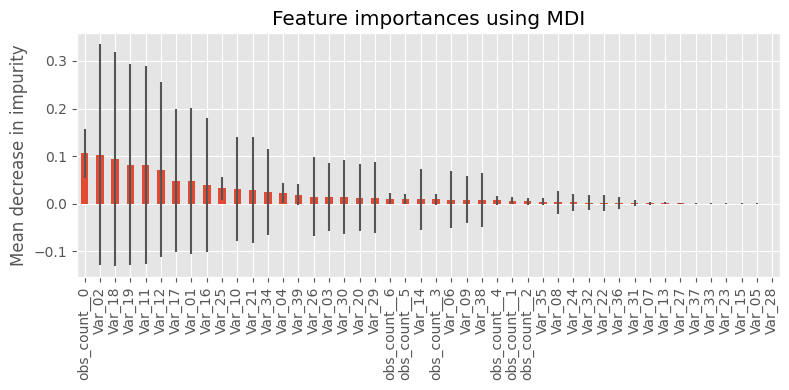

In [4]:
def plot_importance(clf):
    importances = clf.feature_importances_
    forest_importances = pd.Series(importances, index=x_labels)
    sorted_idx = np.argsort(-forest_importances)
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    forest_importances[sorted_idx].plot.bar(yerr=std[sorted_idx], ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    return sorted_idx

sorted_idx = plot_importance(clf_rf)

## Logistic regression

- The standard paramters for logistic regression already incorporate L2 regularization

              precision    recall  f1-score   support

  No default       0.97      0.84      0.90     33790
     Default       0.20      0.65      0.31      2084

    accuracy                           0.83     35874
   macro avg       0.59      0.74      0.61     35874
weighted avg       0.93      0.83      0.87     35874



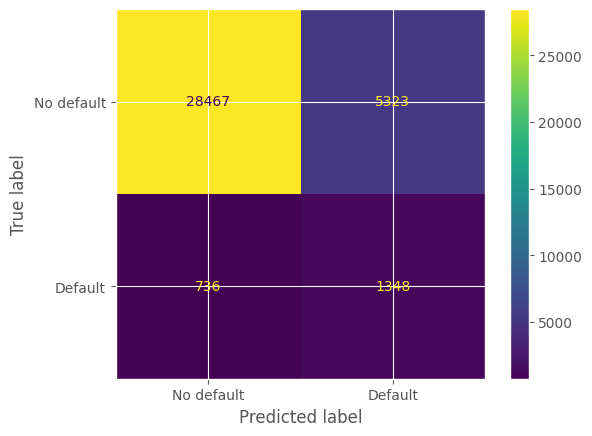

In [5]:
def train_lr(X_train, y_train, y_test):
    clf = LogisticRegression(
        n_jobs=-1,
        class_weight={0: 1, 1: 10},
        random_state=0,
    ).fit(X_train, y_train)

    y_p = clf.predict(X_test)

    print(classification_report(y_test, y_p, target_names=['No default', 'Default']))

    cm = confusion_matrix(y_test, y_p, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No default', 'Default'])
    disp.plot()
    plt.show()
    return clf, y_p


X_best_subset = X[[x_labels[i] for i in sorted_idx[:10]]].copy()
# the random state is preserved so its the same rows just with less columns
X_train, X_test, y_train, y_test = train_test_split(X_best_subset, default, stratify=default,test_size=0.33, random_state=42)

clf_lr, pred_lr = train_lr(X_train, y_train, y_test)

The performance of logistic regression is pretty good when we compare it to random forest. We can correctly classify 65% of all defaults using a linear algorithm when the complex structure of random forest can classify 75% of them.

# Imputed case

So right now I will reapeat the procedure to find out if there was some additional information in the missing data.

In [6]:
df = pd.read_csv('data/df_imputed.csv', index_col=0)
X, default, X_train, X_test, y_train, y_test = split_data(df)

## Random forest

              precision    recall  f1-score   support

  No default       0.99      0.87      0.92     45556
     Default       0.27      0.79      0.40      2857

    accuracy                           0.86     48413
   macro avg       0.63      0.83      0.66     48413
weighted avg       0.94      0.86      0.89     48413



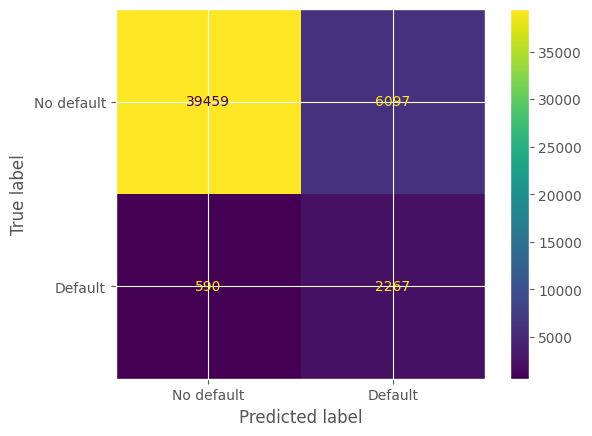

In [7]:
clf_rf_imp = train_rf(X_train, y_train, y_test)

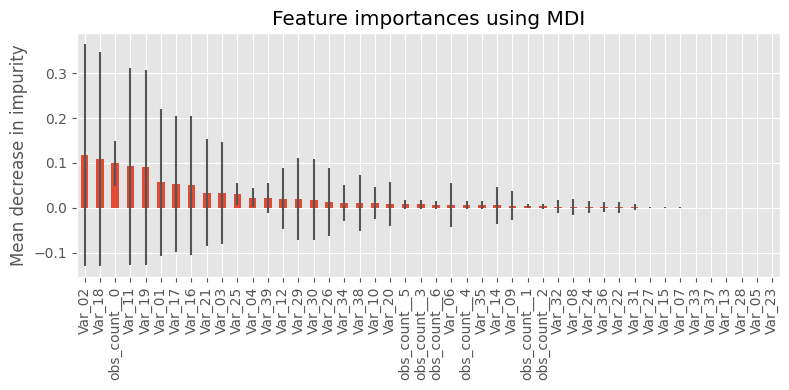

In [8]:
sorted_idx2 = plot_importance(clf_rf_imp)

## Logistic regression

              precision    recall  f1-score   support

  No default       0.98      0.81      0.89     45556
     Default       0.20      0.75      0.31      2857

    accuracy                           0.81     48413
   macro avg       0.59      0.78      0.60     48413
weighted avg       0.93      0.81      0.85     48413



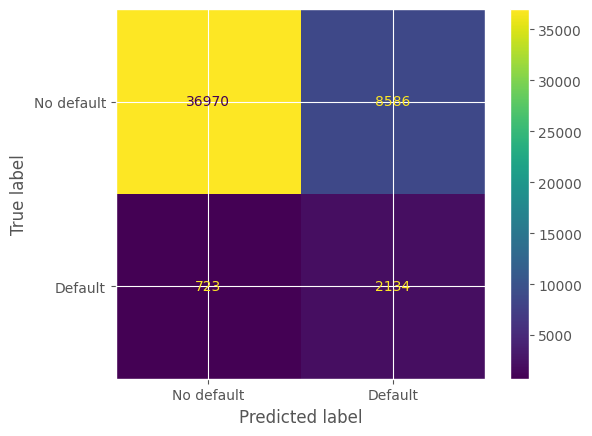

In [9]:
X_best_subset = X[[x_labels[i] for i in sorted_idx2[:10]]].copy()
X_train, X_test, y_train, y_test = train_test_split(X_best_subset, default, stratify=default,test_size=0.33, random_state=42)

clf_lr_imp, pred_lr = train_lr(X_train, y_train, y_test)

# AUC and PR curves for logistic regression

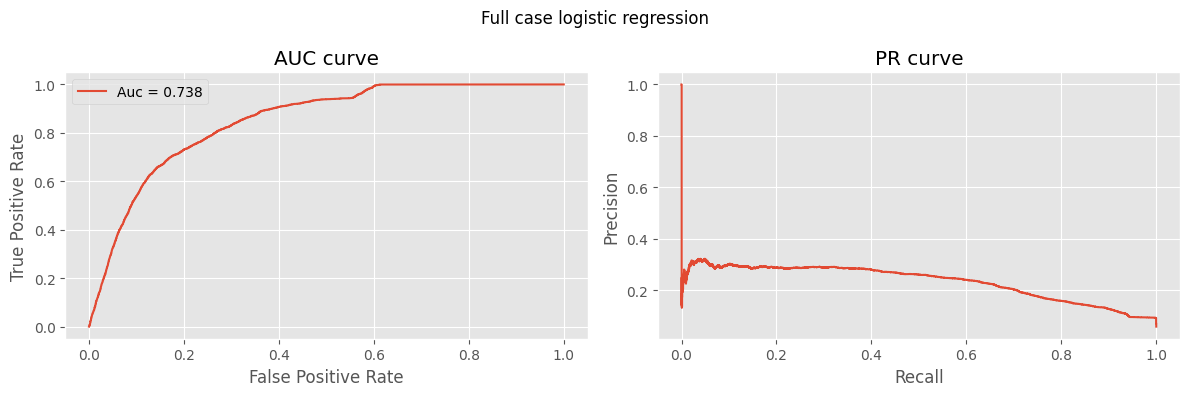

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))


def roc_pr_curve(clf, subset):
    ax1.set_title("AUC curve")
    ax2.set_title("PR curve")
    X_best_subset = X[[x_labels[i] for i in subset[:10]]].copy()
    X_train, X_test, y_train, y_test = train_test_split(X_best_subset, default, stratify=default,test_size=0.33, random_state=42)

    y_score = clf.decision_function(X_test)
    y_pred = clf.predict(X_test)
    auc = round(roc_auc_score(y_test, y_pred), 3)

    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

    prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

    roc_display.plot(ax=ax1)
    pr_display.plot(ax=ax2)
    ax1.legend([f'Auc = {auc}'])

roc_pr_curve(clf_lr, sorted_idx)
fig.suptitle("Full case logistic regression")
plt.tight_layout()

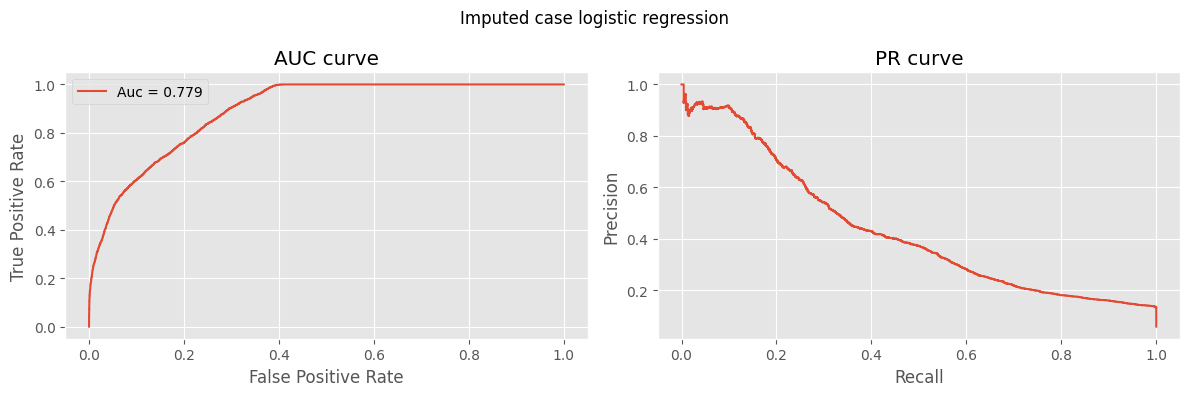

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
roc_pr_curve(clf_lr_imp, sorted_idx2)
fig.suptitle("Imputed case logistic regression")
plt.tight_layout()

- The model that comes from the full case analysis performs better achieving higher AUC score. Also interesting aspect is that we can achieve 100% classification of true defaults while having 40% of false alarms when the full case model achieves it at 60% of false alarms.
- depending on the costs associated with further analysis of miss classified cases it is possible to optimeze the threshold at which we classify them as defaults.
- the pr curve for full case model tells that it is a pretty bad classifier as the default predictions contains alot of false positive cases across all thresholds and the imputed case provides a better tradeoff.

# Conclusion

- There is a 10% improvment in the ability to predict default of a company by addingthe imputted data cases, so I think that it was a correct decision to impute them with 0 as these were not missing at random cases
- It looks like it is still highly linear problem as the random forest performs only slighltly better on the imputed data.
- the imputed case model is definetely performing model.

In [21]:
X_best = X[[x_labels[i] for i in sorted_idx2[:10]]].copy()
X_best = pd.concat([X_best, default], axis=1)
X_best.to_csv('data/df_best.csv')